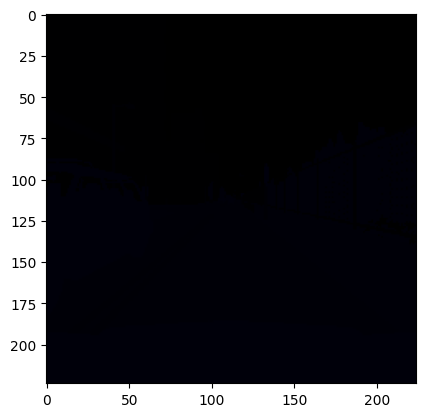

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

class_names = [
     "Unlabeled",
     "Building",
     "Fence",
     "Other",
     "Pedestrian",
     "Pole",
     "Roadline",
     "Road",
     "Sidewalk",
     "Vegetation",
     "Car",
     "Wall",
     "Traffic sign"
    ]

img_path = "/home/walke/college/cv/ass4/data1/dataset_224/train/images/02_00_000.png"
label_path = "/home/walke/college/cv/ass4/data1/dataset_224/train/labels/02_00_000.png"

mask = cv2.imread(label_path)
plt.imshow(mask)


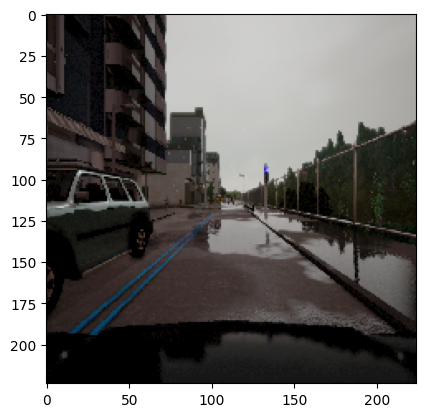

In [2]:

img = cv2.imread(img_path)
plt.imshow(img)
   

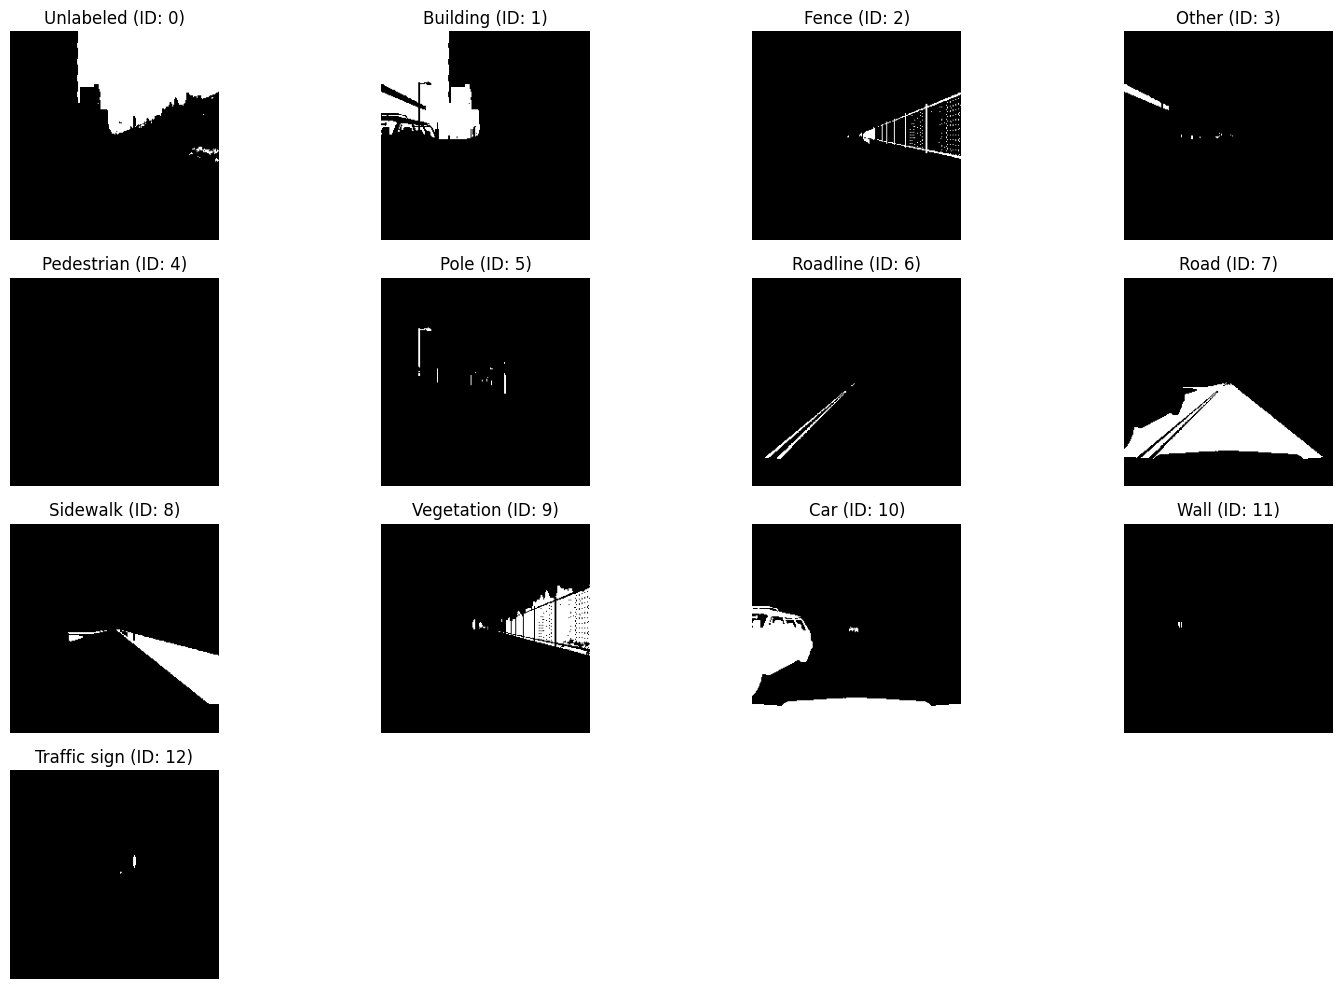

In [3]:
          

binary_masks = {}
for class_id in range(13):
    binary_mask = (mask == class_id).astype(np.uint8) * 100

    binary_mask = cv2.cvtColor(binary_mask, cv2.COLOR_BGR2GRAY)

    binary_masks[class_id] = binary_mask

    # print(binary_mask)

    # print("-------------------------------------------------------------")
    
    

plt.figure(figsize=(15, 10))
rows, cols = 4, 4 
    
for i, class_id in enumerate(range(13)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(binary_masks[class_id], cmap='gray')
    plt.title(f"{class_names[class_id]} (ID: {class_id})")
    plt.axis('off')
    
plt.tight_layout()
plt.show()
    

    


In [4]:
# https://medium.com/@mohit_gaikwad/overview-fully-convolutional-network-for-semantic-segmentation-b4ef92eeb8c4


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Data(Dataset):
    def __init__(self, root_dir, transform=None):

        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.image_filenames = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.png')])
        self.label_filenames = sorted([f for f in os.listdir(self.label_dir) if f.endswith('.png')])

        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = cv2.imread(img_path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        # print("Image Path:", img_path) 


        label_path = os.path.join(self.label_dir, self.label_filenames[idx])
        mask = cv2.imread(label_path) 
        mask = mask[:,:,2]

        if self.transform:
            image = self.transform(image)


        mask = torch.tensor(mask, dtype=torch.long) 

        return image, mask

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


batch_size = 32

dataset = Data(root_dir="/home/walke/college/cv/ass4/data1/dataset_224/train", transform=transform)

train_size = int(0.9 * len(dataset))

val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

test_dataset = Data(root_dir="/home/walke/college/cv/ass4/data1/dataset_224/test", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


len(dataset)

2000

In [5]:

device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torchmetrics.segmentation

class FCNBase(nn.Module):
    def __init__(self, num_classes=13):
        super(FCNBase, self).__init__()
        self.num_classes = num_classes
        
    
        vgg19 = models.vgg19(pretrained=True)
        self.features = vgg19.features
        
        # Conv layers 
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=7, padding=3)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()
        
        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()
        
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)

    def freeze_backbone(self):
        for param in self.features.parameters():
            param.requires_grad = False

    def forward_features(self, x):

        input_size = x.size()
        results = []
        
        # pool3 output 1/8 
        for i in range(19): 
            x = self.features[i](x)
        results.append(x)  # pool3 output
        
        # pool4 output 1/16 
        for i in range(19, 28):
            x = self.features[i](x)
        results.append(x)  # pool4 output
        
        # pool5 output 1/32 
        for i in range(28, 37):
            x = self.features[i](x)
        results.append(x)  # pool5 output
        
        
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.drop6(x)
        
        x = self.fc7(x)
        x = self.relu7(x)
        x = self.drop7(x)
        
        x = self.score_fr(x)
        
        return x, results, input_size
        
    def initialize_weights(self):
        vgg19 = models.vgg19(pretrained=True)
        
        # Convert FC weights to Conv weights
        fc6_weight = vgg19.classifier[0].weight.view(4096, 512, 7, 7)
        fc6_bias = vgg19.classifier[0].bias
        self.fc6.weight.data.copy_(fc6_weight)
        self.fc6.bias.data.copy_(fc6_bias)
        
        fc7_weight = vgg19.classifier[3].weight.view(4096, 4096, 1, 1)
        fc7_bias = vgg19.classifier[3].bias
        self.fc7.weight.data.copy_(fc7_weight)
        self.fc7.bias.data.copy_(fc7_bias)


In [ ]:

class FCN32s(FCNBase):
    def __init__(self, num_classes=13):
        super(FCN32s, self).__init__(num_classes=num_classes)
        # deconvolution 
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16, bias=False)
        self._initialize_weights()
        
    def _initialize_weights(self):
        super().initialize_weights()
        nn.init.kaiming_normal_(self.upscore.weight)
    
    def forward(self, x):
        x, _, input_size = self.forward_features(x)
        
        # Upsample
        x = self.upscore(x)
        
        # Crop 
        if x.size()[2] != input_size[2] or x.size()[3] != input_size[3]:
            x = x[:, :, :input_size[2], :input_size[3]]
        
        return x


In [ ]:

class FCN16s(FCNBase):
    def __init__(self, num_classes=13):
        super(FCN16s, self).__init__(num_classes=num_classes)
        
        # skip connections
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        
        # deconvolution
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, padding=8, bias=False)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        super().initialize_weights()
        
        # score_pool4
        self.score_pool4.weight.data.zero_()
        self.score_pool4.bias.data.zero_()
        
        # deconvolution weights
        nn.init.kaiming_normal_(self.upscore2.weight)
        nn.init.kaiming_normal_(self.upscore16.weight)
                    
    def forward(self, x):
        
        x, pool_outputs, input_size = self.forward_features(x)
        _, pool4, _ = pool_outputs
        
        # pool4
        score_pool4 = self.score_pool4(pool4)
        
        # Upsample deconvolution
        upscore2 = self.upscore2(x)
        
        # Crop score_pool4 dimensions
        h = score_pool4.size()[2]
        w = score_pool4.size()[3]
        if upscore2.size()[2] != h or upscore2.size()[3] != w:
            upscore2 = upscore2[:, :, :h, :w]
        
        # Add 
        fuse_pool4 = upscore2 + score_pool4
        
        # Upsample original image size with deconvolution
        out = self.upscore16(fuse_pool4)
        
        # Crop 
        if out.size()[2] != input_size[2] or out.size()[3] != input_size[3]:
            out = out[:, :, :input_size[2], :input_size[3]]
        
        return out


In [ ]:

class FCN8s(FCNBase):
    def __init__(self, num_classes=13):
        super(FCN8s, self).__init__(num_classes=num_classes)
        
        # skip connections
        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        
        # deconvolution
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        super().initialize_weights()
        
        # score_pool3 and score_pool4
        self.score_pool3.weight.data.zero_()
        self.score_pool3.bias.data.zero_()
        self.score_pool4.weight.data.zero_()
        self.score_pool4.bias.data.zero_()
        
        # deconvolution weights
        nn.init.kaiming_normal_(self.upscore2.weight)
        nn.init.kaiming_normal_(self.upscore_pool4.weight)
        nn.init.kaiming_normal_(self.upscore8.weight)
                    
    def forward(self, x):
        
        x, pool_outputs, input_size = self.forward_features(x)
        pool3, pool4, _ = pool_outputs
        
        # pool3 and pool4
        score_pool3 = self.score_pool3(pool3)
        score_pool4 = self.score_pool4(pool4)
        
        # upsample score_fr with deconvolution
        upscore2 = self.upscore2(x)
        
        # Crop to match score_pool4
        h = score_pool4.size()[2]
        w = score_pool4.size()[3]
        if upscore2.size()[2] != h or upscore2.size()[3] != w:
            upscore2 = upscore2[:, :, :h, :w]
        
        # Add 
        fuse_pool4 = upscore2 + score_pool4
        
        # Second upsample fused result with deconvolution
        upscore_pool4 = self.upscore_pool4(fuse_pool4)
        
        # Crop to match score_pool3 
        h = score_pool3.size()[2]
        w = score_pool3.size()[3]
        if upscore_pool4.size()[2] != h or upscore_pool4.size()[3] != w:
            upscore_pool4 = upscore_pool4[:, :, :h, :w]
        
        # Add 
        fuse_pool3 = upscore_pool4 + score_pool3
        
        # Final upsample fused result with deconvolution
        out = self.upscore8(fuse_pool3)
        
        # Crop 
        if out.size()[2] != input_size[2] or out.size()[3] != input_size[3]:
            out = out[:, :, :input_size[2], :input_size[3]]
        
        return out


In [ ]:

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_miou': []}
    
    val_iou = torchmetrics.segmentation.MeanIoU(num_classes=model.num_classes).to(device)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_pixels = 0
        
        for inputs, masks in train_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            if outputs.size()[2:] != masks.size()[1:]:
                outputs = F.interpolate(outputs, size=masks.size()[1:], mode='bilinear', align_corners=False)
            
            loss = criterion(outputs, masks)
            
           
            loss.backward()
            optimizer.step()
            
          
            running_loss += loss.item() * inputs.size(0)
            pred = torch.argmax(outputs, dim=1)
            running_corrects += (pred == masks).sum().item()
            total_pixels += masks.numel()
            
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / total_pixels
        
        # Validation 
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_pixels = 0
        val_iou.reset()
        
        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs = inputs.to(device)
                masks = masks.to(device)
                
                outputs = model(inputs)
                
                
                if outputs.size()[2:] != masks.size()[1:]:
                    outputs = F.interpolate(outputs, size=masks.size()[1:], mode='bilinear', align_corners=False)
                
                loss = criterion(outputs, masks)
                
                val_loss += loss.item() * inputs.size(0)
                pred = torch.argmax(outputs, dim=1)
                val_corrects += (pred == masks).sum().item()
                val_pixels += masks.numel()
                
                val_iou.update(pred, masks)
                
        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects / val_pixels
        val_epoch_miou = val_iou.compute().item()
        
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['val_acc'].append(val_epoch_acc)
        history['val_miou'].append(val_epoch_miou)
        
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | '
              f'Train Acc: {epoch_acc:.4f} | '
              f'Val Loss: {val_epoch_loss:.4f} | '
              f'Val Acc: {val_epoch_acc:.4f} | '
              f'Val mIoU: {val_epoch_miou:.4f}')
        
    return model, history


In [ ]:

def evaluate_model(model, test_loader, device):
    model.eval()
    test_corrects = 0
    test_pixels = 0

    test_iou = torchmetrics.segmentation.MeanIoU(num_classes=model.num_classes).to(device)
    
    with torch.no_grad():
        for inputs, masks in test_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)
            
            outputs = model(inputs)

            if outputs.size()[2:] != masks.size()[1:]:
                outputs = F.interpolate(outputs, size=masks.size()[1:], mode='bilinear', align_corners=False)
            
            pred = torch.argmax(outputs, dim=1)
            test_corrects += (pred == masks).sum().item()
            test_pixels += masks.numel()
   
            test_iou.update(pred, masks)
    
    test_acc = test_corrects / test_pixels
    test_miou = test_iou.compute().item()
    
    print(f'Test Accuracy: {test_acc:.4f} | Test mIoU: {test_miou:.4f}')
    
    return test_acc, test_miou



In [ ]:

def visualize_results(model, test_loader, device, n_samples=5):
    model.eval()
    
    images, masks = next(iter(test_loader))
    images = images.to(device)
    masks = masks.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        
        if outputs.size()[2:] != masks.size()[1:]:
            outputs = F.interpolate(outputs, size=masks.size()[1:], mode='bilinear', align_corners=False)
            
        predictions = torch.argmax(outputs, dim=1)
    
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    predictions = predictions.cpu().numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    indices = np.random.choice(images.shape[0], n_samples, replace=False)
    
    plt.figure(figsize=(15, 5*n_samples))
    
    for i, idx in enumerate(indices):
        # Original image
        plt.subplot(n_samples, 3, i*3+1)
        img = images[idx].transpose(1, 2, 0) * std + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(n_samples, 3, i*3+2)
        plt.imshow(masks[idx], cmap='inferno')
        plt.title('Ground Truth')
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(n_samples, 3, i*3+3)
        plt.imshow(predictions[idx], cmap='inferno')
        plt.title('Prediction')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_metrics(history):
    plt.figure(figsize=(18, 5))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot mIoU
    plt.subplot(1, 3, 3)
    plt.plot(history['val_miou'], label='Validation mIoU')
    plt.title('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
 


Training FCN-8s model...


/home/walke/college/cv/pfizer/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/walke/college/cv/pfizer/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 | Train Loss: 1.1188 | Train Acc: 0.6166 | Val Loss: 0.4016 | Val Acc: 0.8758 | Val mIoU: 0.7188
Epoch 2/5 | Train Loss: 0.3455 | Train Acc: 0.8886 | Val Loss: 0.2983 | Val Acc: 0.9007 | Val mIoU: 0.7542
Epoch 3/5 | Train Loss: 0.2810 | Train Acc: 0.9041 | Val Loss: 0.2576 | Val Acc: 0.9099 | Val mIoU: 0.7694
Epoch 4/5 | Train Loss: 0.2499 | Train Acc: 0.9120 | Val Loss: 0.2381 | Val Acc: 0.9139 | Val mIoU: 0.7717
Epoch 5/5 | Train Loss: 0.2321 | Train Acc: 0.9167 | Val Loss: 0.2206 | Val Acc: 0.9199 | Val mIoU: 0.7792
Evaluating FCN-8s on test set...
Test Accuracy: 0.9195 | Test mIoU: 0.7789
FCN-8s Test Accuracy: 0.9195, Test mIoU: 0.7789


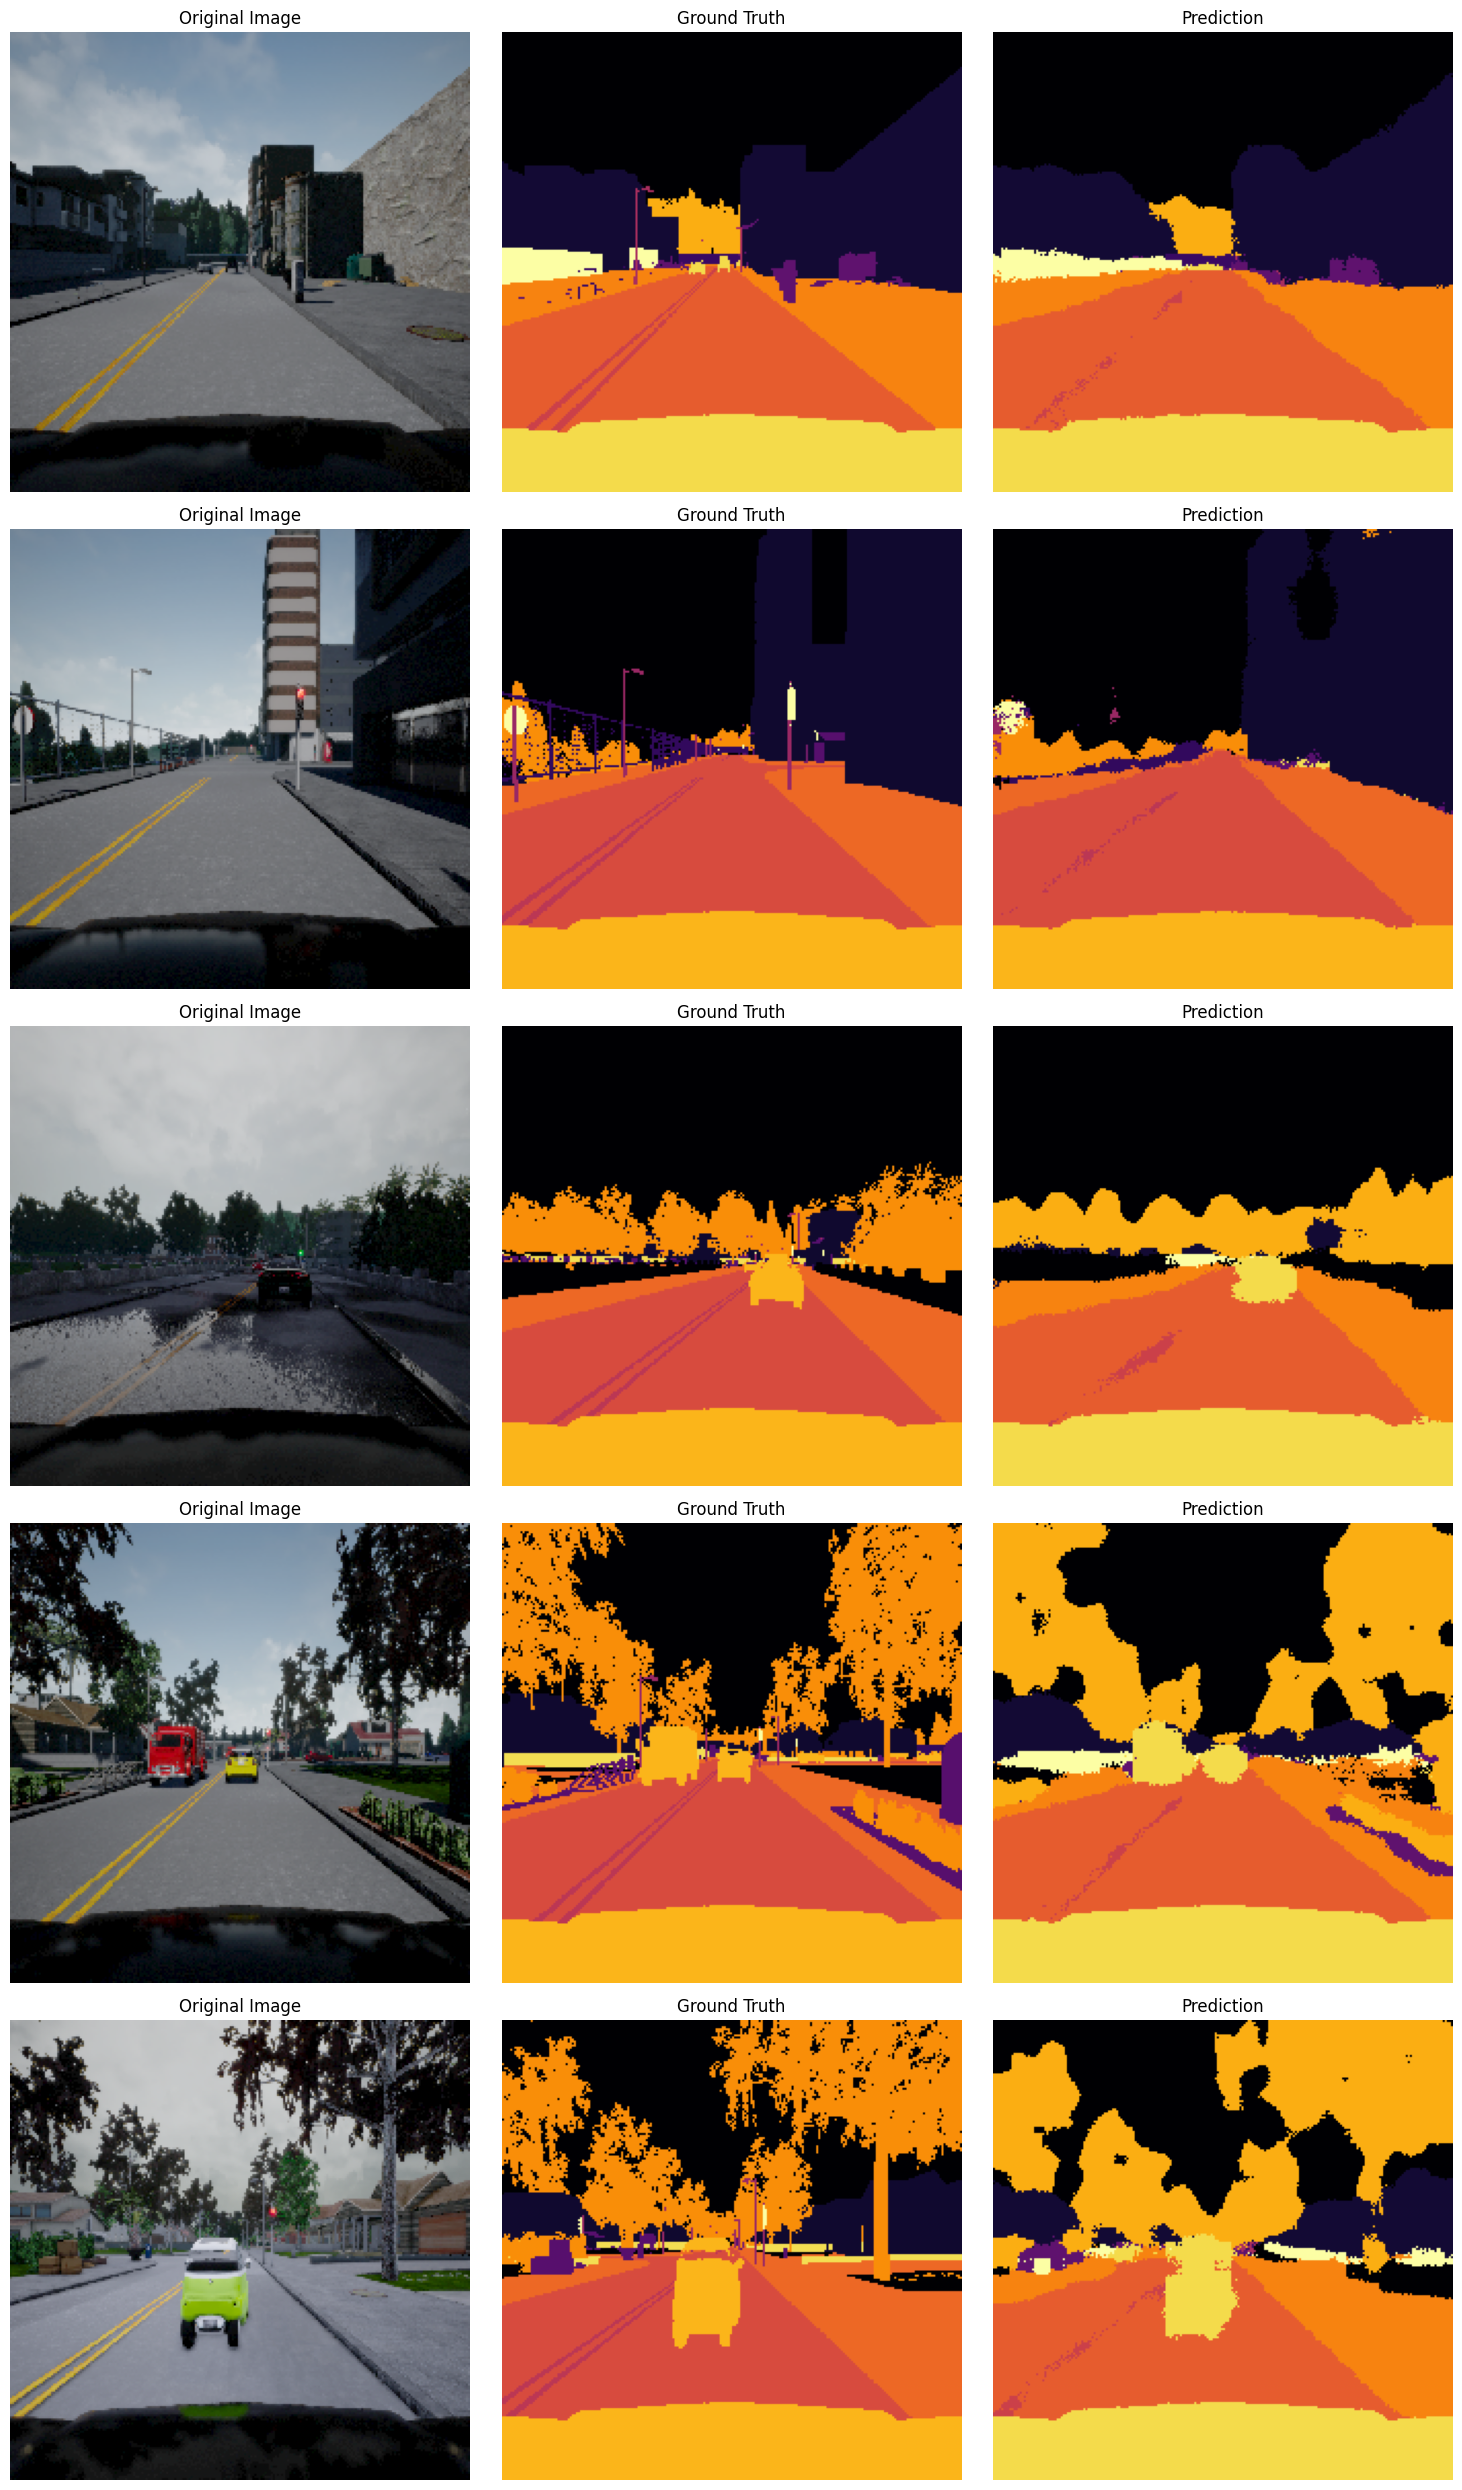

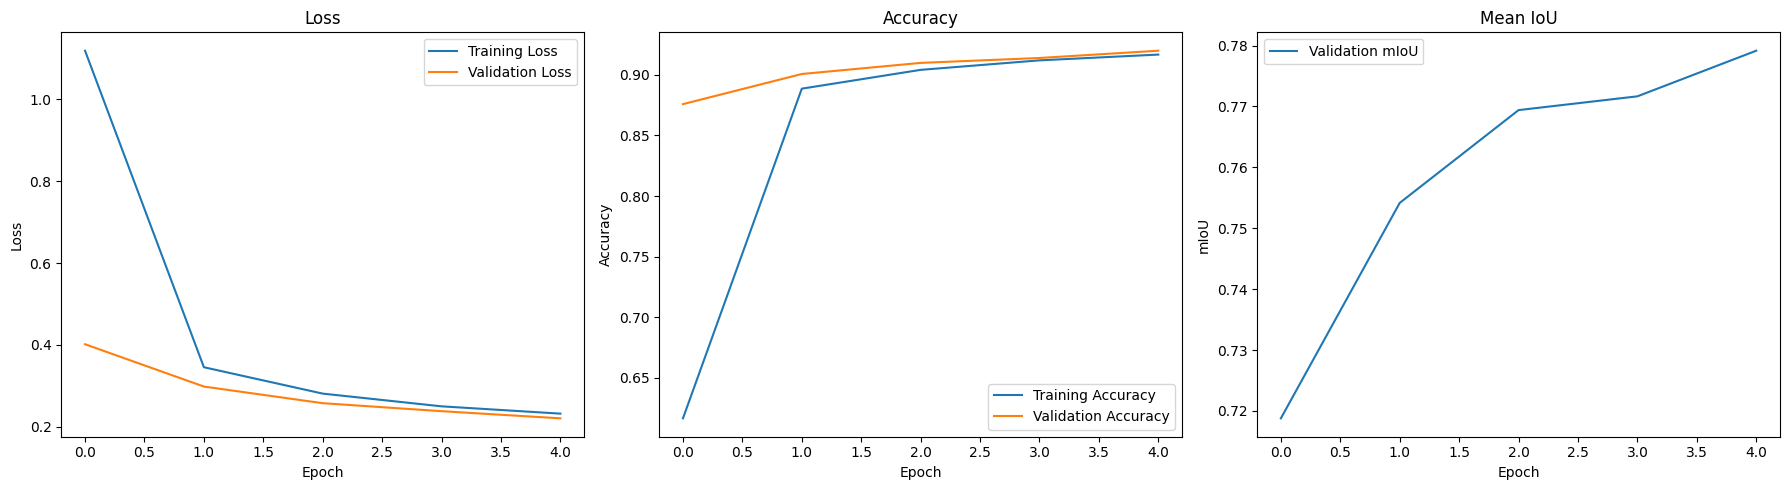

In [ ]:
NUM_CLASSES = 13  
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 5
    

criterion = nn.CrossEntropyLoss()


print("Training FCN-8s model...")
model_fcn8s = FCN8s(num_classes=NUM_CLASSES)
model_fcn8s.freeze_backbone()
optimizer = torch.optim.AdamW(model_fcn8s.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model_fcn8s, history_fcn8s = train_model(model_fcn8s, train_loader, val_loader, criterion, optimizer, device, EPOCHS)


print("Evaluating FCN-8s on test set...")
test_acc, test_miou = evaluate_model(model_fcn8s, test_loader, device)
print(f"FCN-8s Test Accuracy: {test_acc:.4f}, Test mIoU: {test_miou:.4f}")


visualize_results(model_fcn8s, test_loader, device)


plot_metrics(history_fcn8s)




Training FCN-16s model...
Epoch 1/5 | Train Loss: 0.9549 | Train Acc: 0.6718 | Val Loss: 0.3953 | Val Acc: 0.8686 | Val mIoU: 0.6930
Epoch 2/5 | Train Loss: 0.3551 | Train Acc: 0.8790 | Val Loss: 0.3060 | Val Acc: 0.8922 | Val mIoU: 0.7333
Epoch 3/5 | Train Loss: 0.2955 | Train Acc: 0.8960 | Val Loss: 0.2716 | Val Acc: 0.9020 | Val mIoU: 0.7491
Epoch 4/5 | Train Loss: 0.2664 | Train Acc: 0.9037 | Val Loss: 0.2508 | Val Acc: 0.9075 | Val mIoU: 0.7507
Epoch 5/5 | Train Loss: 0.2477 | Train Acc: 0.9087 | Val Loss: 0.2385 | Val Acc: 0.9111 | Val mIoU: 0.7612
Evaluating FCN-16s on test set...
Test Accuracy: 0.9099 | Test mIoU: 0.7607
FCN-16s Test Accuracy: 0.9099, Test mIoU: 0.7607


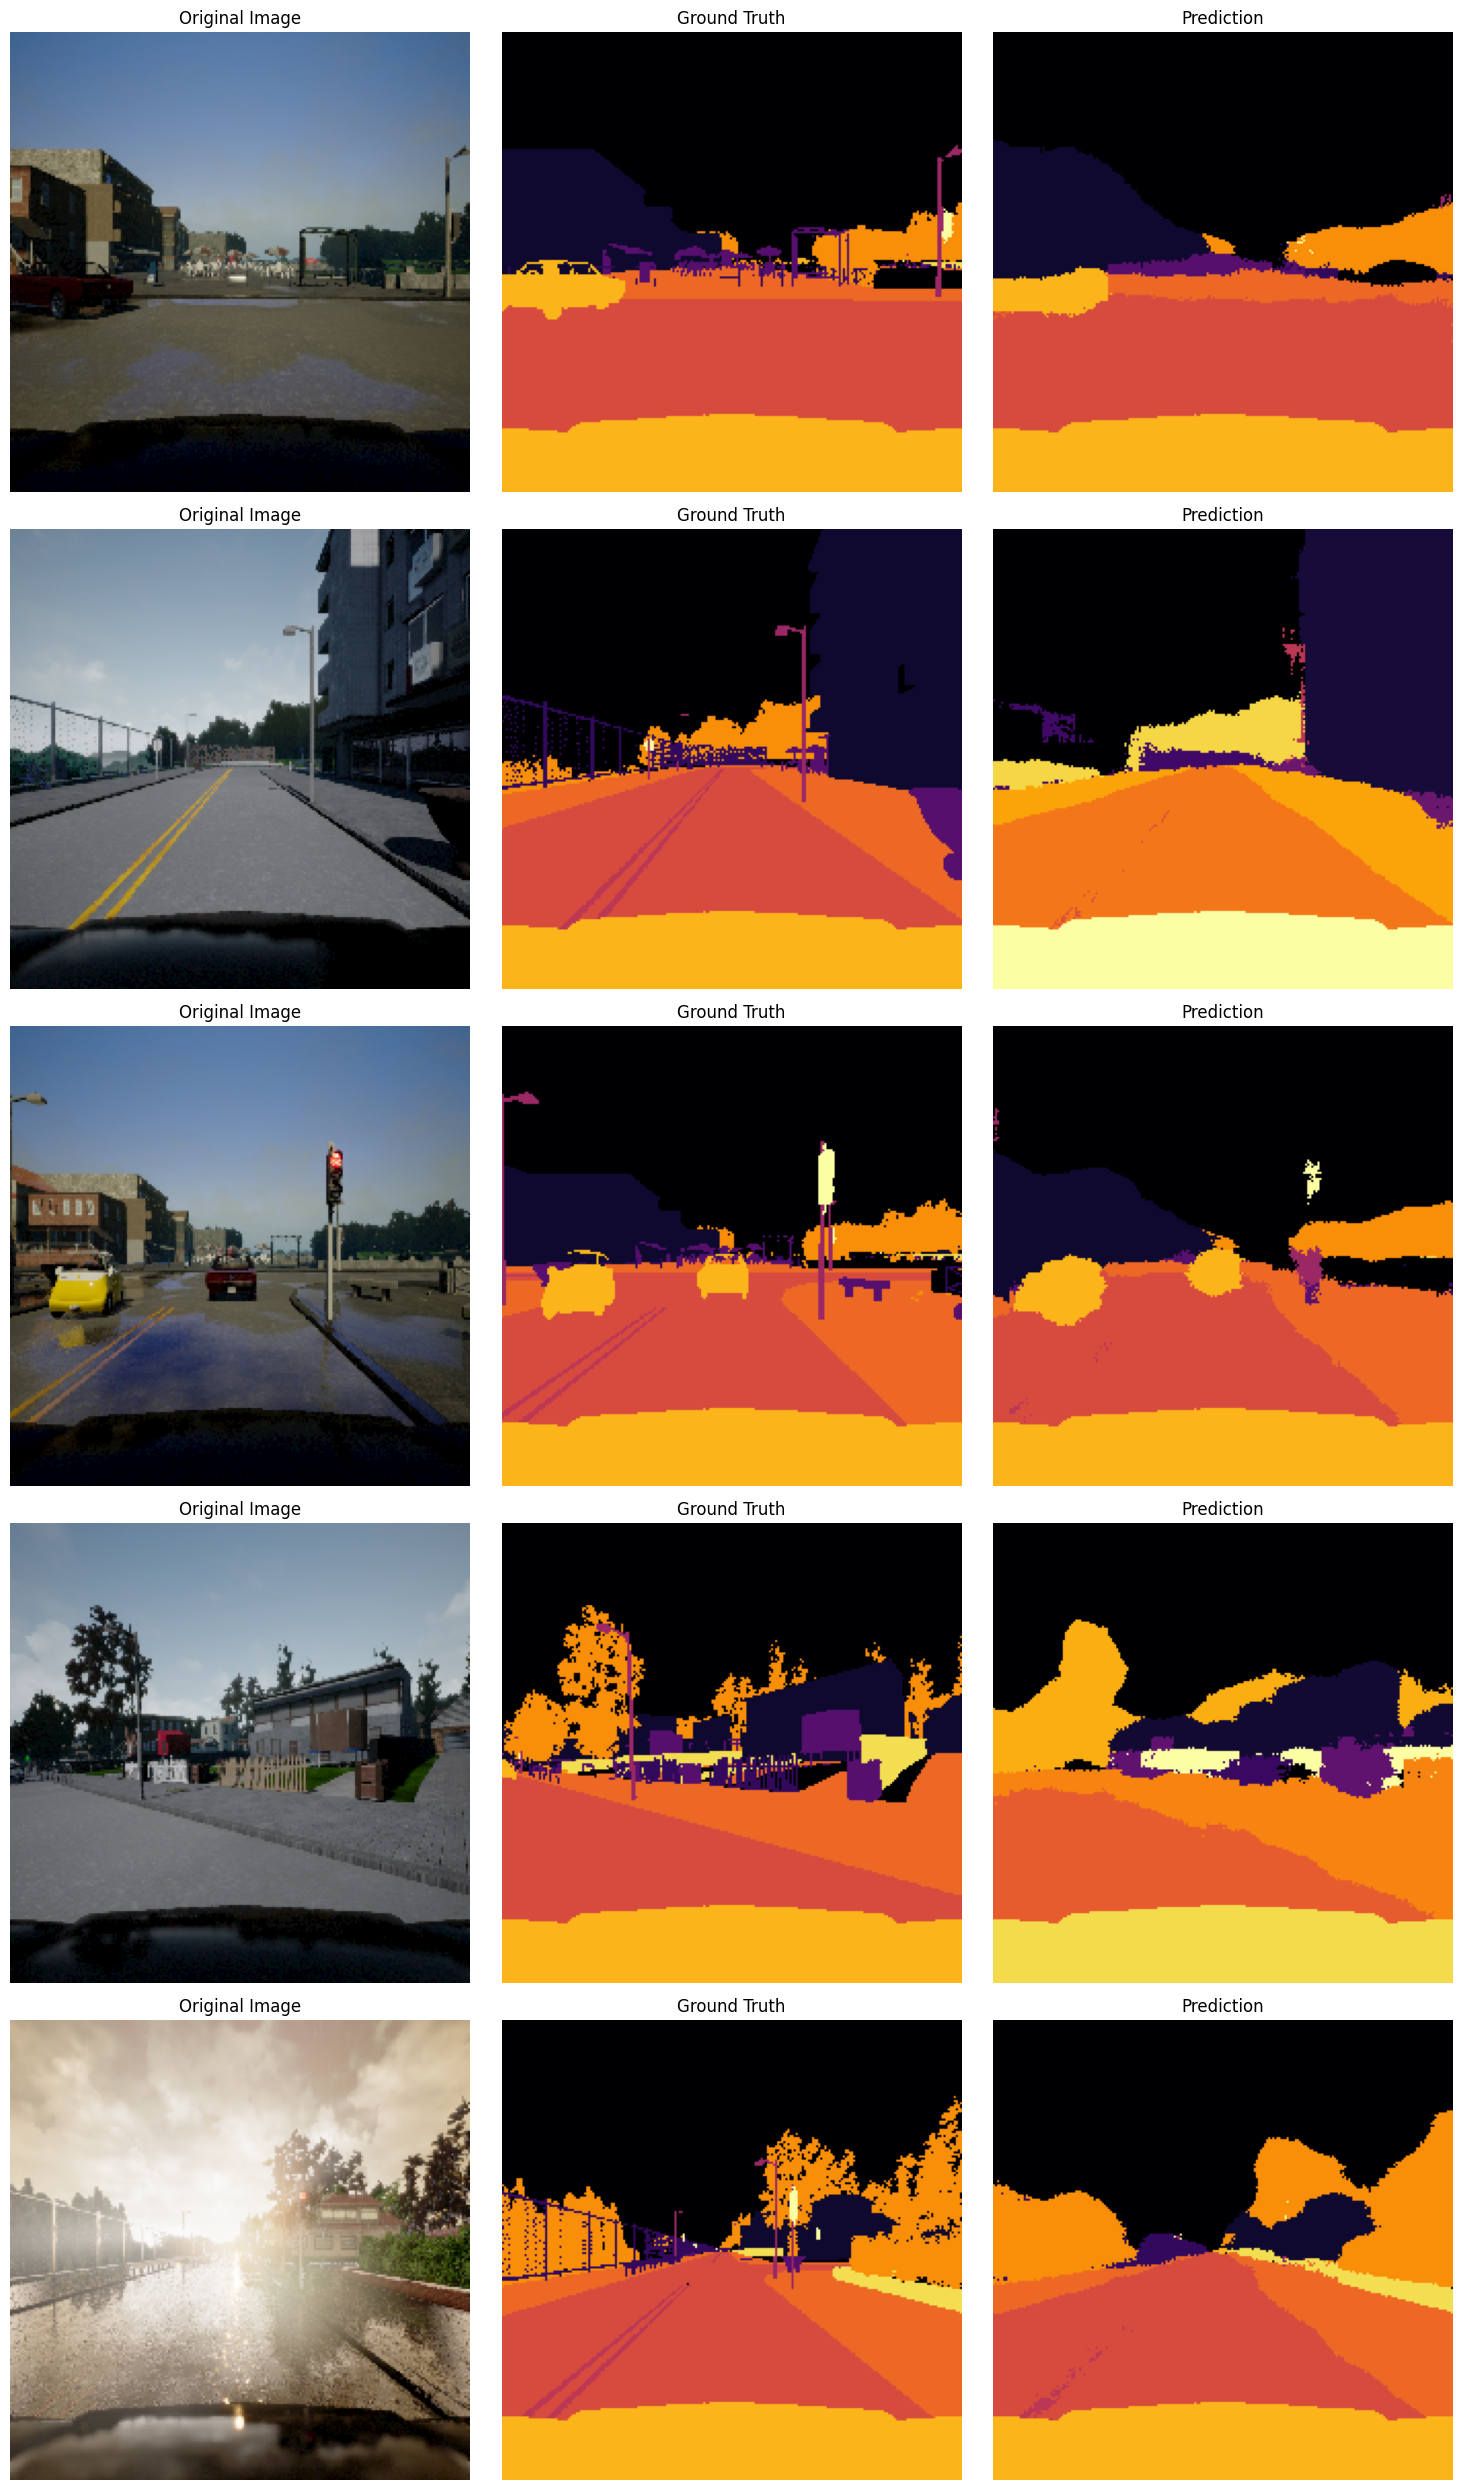

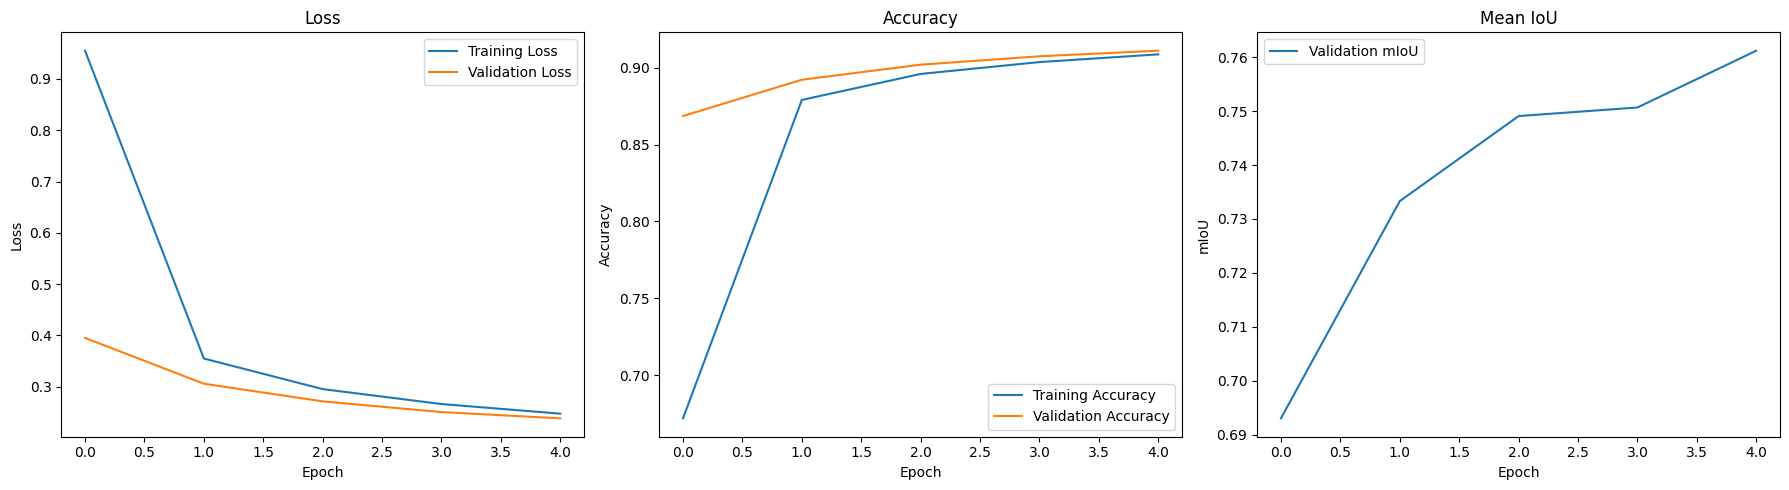

In [ ]:
print("Training FCN-16s model...")
model_fcn16s = FCN16s(num_classes=NUM_CLASSES)
model_fcn16s.freeze_backbone()
optimizer = torch.optim.AdamW(model_fcn16s.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model_fcn16s, history_fcn16s = train_model(model_fcn16s, train_loader, val_loader, criterion, optimizer, device, EPOCHS)


print("Evaluating FCN-16s on test set...")
test_acc, test_miou = evaluate_model(model_fcn16s, test_loader, device)
print(f"FCN-16s Test Accuracy: {test_acc:.4f}, Test mIoU: {test_miou:.4f}")

visualize_results(model_fcn16s, test_loader, device)
# Plot training and validation metrics
plot_metrics(history_fcn16s)

Training FCN-32s model...
Epoch 1/5 | Train Loss: 0.8780 | Train Acc: 0.6953 | Val Loss: 0.4381 | Val Acc: 0.8498 | Val mIoU: 0.6499
Epoch 2/5 | Train Loss: 0.4030 | Train Acc: 0.8589 | Val Loss: 0.3448 | Val Acc: 0.8761 | Val mIoU: 0.6916
Epoch 3/5 | Train Loss: 0.3406 | Train Acc: 0.8771 | Val Loss: 0.3123 | Val Acc: 0.8844 | Val mIoU: 0.7133
Epoch 4/5 | Train Loss: 0.3087 | Train Acc: 0.8867 | Val Loss: 0.2906 | Val Acc: 0.8920 | Val mIoU: 0.7221
Epoch 5/5 | Train Loss: 0.2897 | Train Acc: 0.8924 | Val Loss: 0.2754 | Val Acc: 0.8962 | Val mIoU: 0.7265
Evaluating FCN-32s on test set...
Test Accuracy: 0.8947 | Test mIoU: 0.7239
FCN-32s Test Accuracy: 0.8947, Test mIoU: 0.7239


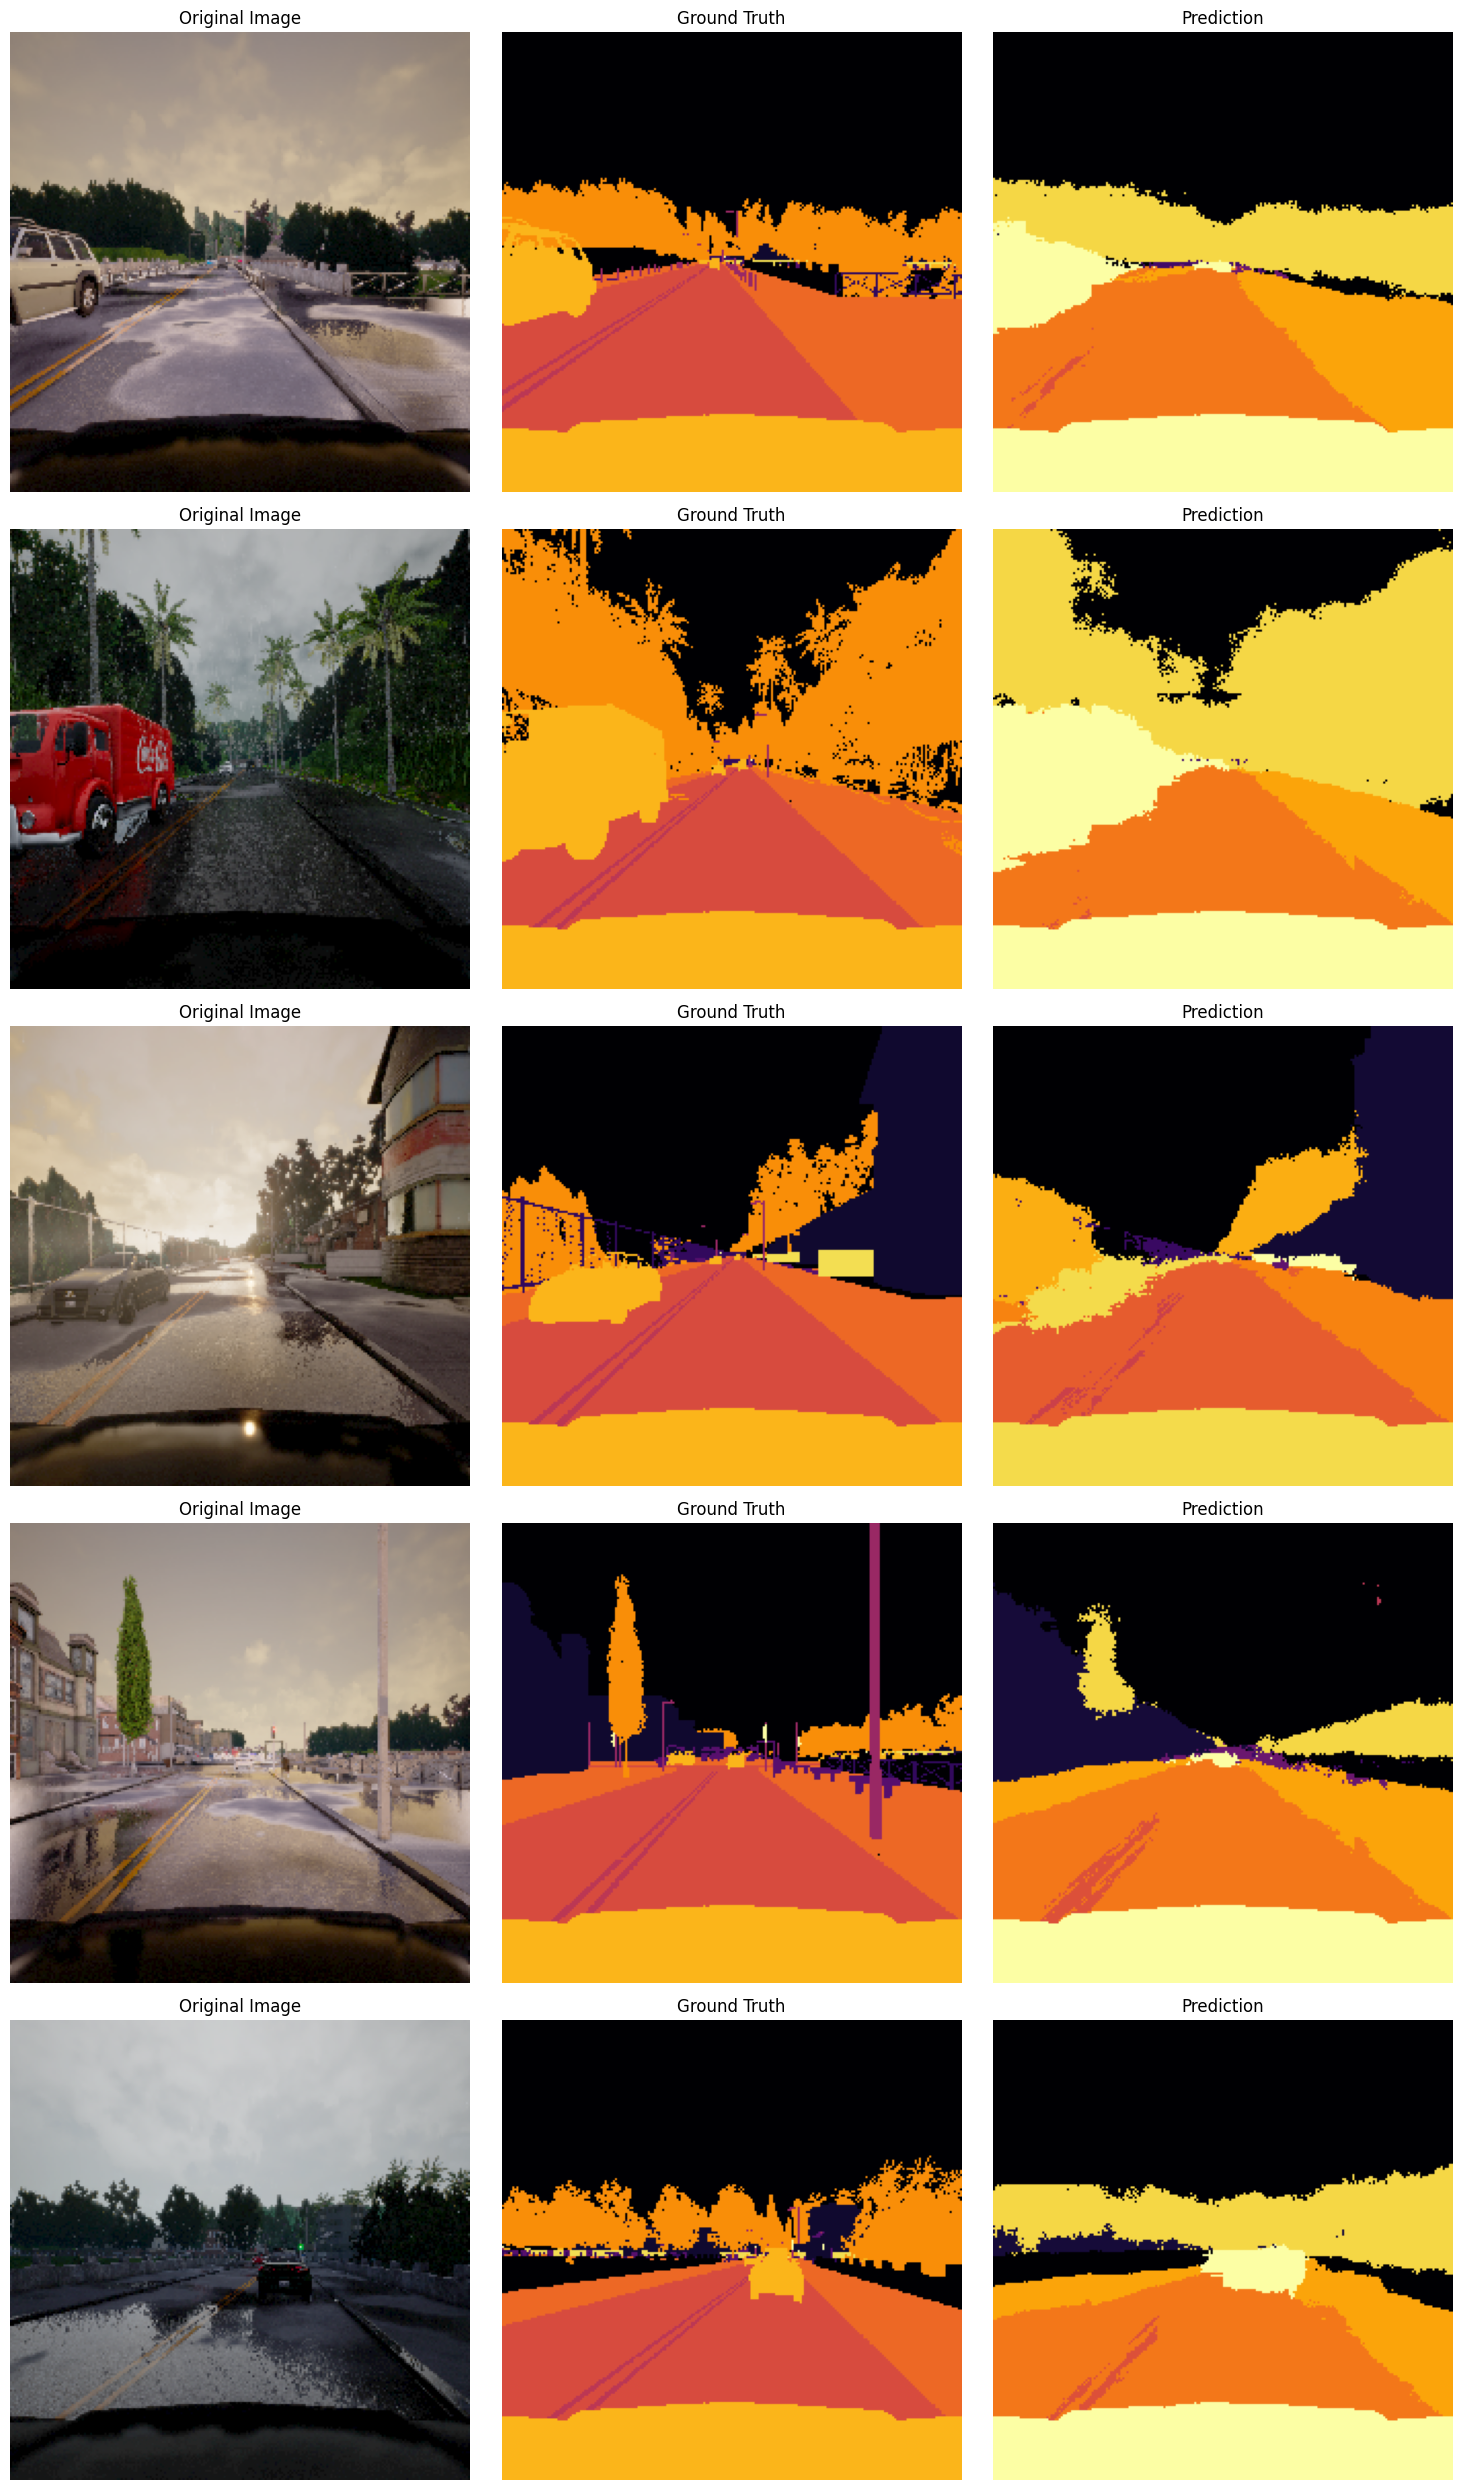

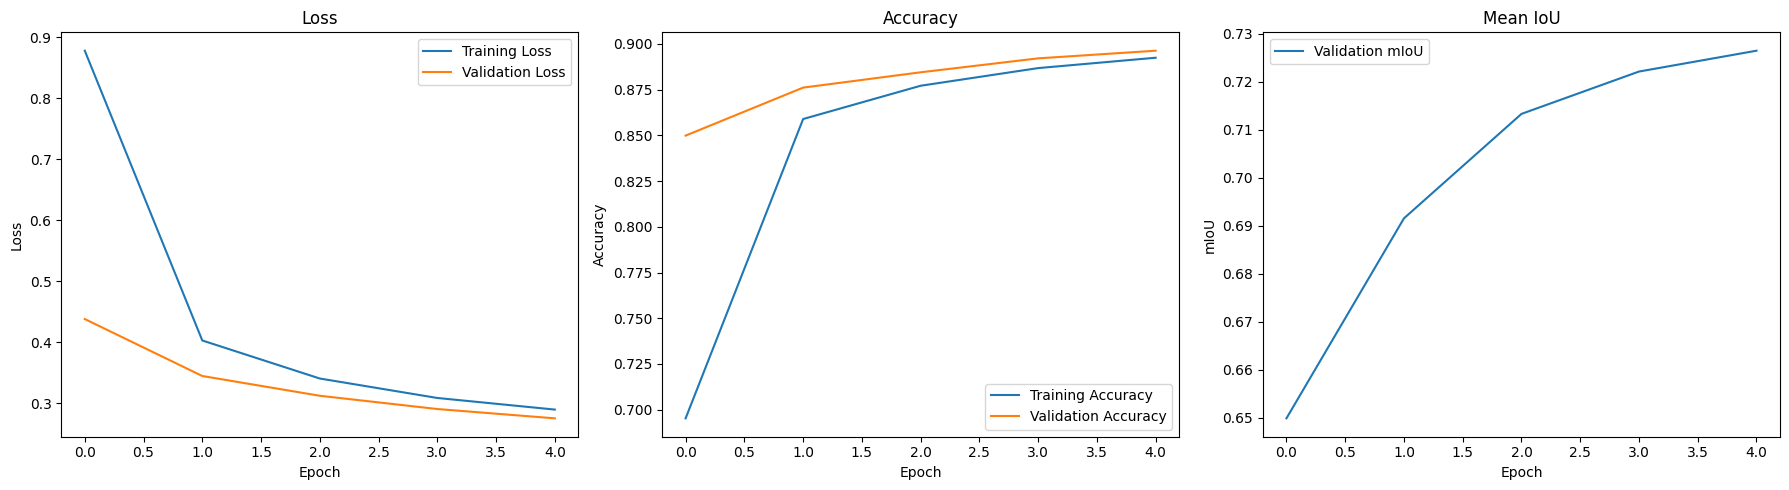

In [ ]:
print("Training FCN-32s model...")
model_fcn32s = FCN32s(num_classes=NUM_CLASSES)
model_fcn32s.freeze_backbone()
optimizer = torch.optim.AdamW(model_fcn32s.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
model_fcn32s, history_fcn32s = train_model(model_fcn32s, train_loader, val_loader, criterion, optimizer, device, EPOCHS)

print("Evaluating FCN-32s on test set...")
test_acc, test_miou = evaluate_model(model_fcn32s, test_loader, device)
print(f"FCN-32s Test Accuracy: {test_acc:.4f}, Test mIoU: {test_miou:.4f}")

visualize_results(model_fcn32s, test_loader, device)
plot_metrics(history_fcn32s)